# DSCOVR EPIC Image Processing

This is an overview on how to get started processing the raw data from the EPIC sensor on the DSCOVR satellite using Python.

We're processing the "Level 1B" data from EPIC here, which contains calibrated and georeferenced data so we don't have to attempt to align the individual per-band images. You can also get the Level 1A data which has the least processing.

You'll have to get the data yourself by "ordering" it (for free) from [here](https://search.earthdata.nasa.gov/search/granules?p=C1282024672-LARC_ASDC&m=0!-156.31940000000003!0!1!0!0%2C2&tl=1452723879!4!!&q=DSCOVR), and downloading over FTP. The raw files are about 175MB each.

For this example we're using an image from 2016/09/21, which you can see [here with NASA's image processing](http://epic.gsfc.nasa.gov/epic-archive/natural/png/epic_1b_20160921201548_01.png).

In [2]:
%pylab inline
%matplotlib inline
from ipy_table import *
import h5py
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
h5py.enable_ipython_completer()

img = h5py.File('epic_1b_20160921201548_01.h5')

Populating the interactive namespace from numpy and matplotlib


The data is provided as an HDF5 file which contains all the individual images, and has an internal structure which provides metadata. NASA provides [some documentation](https://eosweb.larc.nasa.gov/project/dscovr/EPIC_Data_Format_Control_Book_2016-07-01.pdf) on the structure.

We can list the "groups" within this file, which correspond to the individual images from the sensor:

In [3]:
list(img)

['Band317nm',
 'Band325nm',
 'Band340nm',
 'Band388nm',
 'Band443nm',
 'Band551nm',
 'Band680nm',
 'Band688nm',
 'Band764nm',
 'Band780nm']

Within the group for each band, we have the raw image data, as well as some geolocation data:

In [4]:
list(img['Band317nm'])

['Geolocation', 'Image']

We can take a look at the attributes for the geolocation data with regards to Earth, which contains some useful info (if the moon is in the frame, there will be a `Moon` group as well):

In [5]:
make_table([("Attribute", "Value")] + list(img['Band317nm']['Geolocation']['Earth'].attrs.items()))

Attribute,Value
image_band,[9]
earth_north_direction,[-66.42248881]
centroid_equatorial_pixel_size,[ 1583.91174316]
centroid_polar_pixel_size,[ 1578.60119629]
dscovr_ephemeris_x_position,[-1511700.]
dscovr_ephemeris_y_position,[ 252084.1875]
dscovr_ephemeris_z_position,[ 111630.8515625]
dscovr_ephemeris_x_velocity,[-0.02583]
dscovr_ephemeris_y_velocity,[-0.26062]
dscovr_ephemeris_z_velocity,[-0.0374]


The Level 1B data has all the band images rotated and aligned, centred with the middle of the Earth at coordinates `[1024, 1024]`.


Let's take a look at the individual per-band images for this dataset:

/usr/local/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


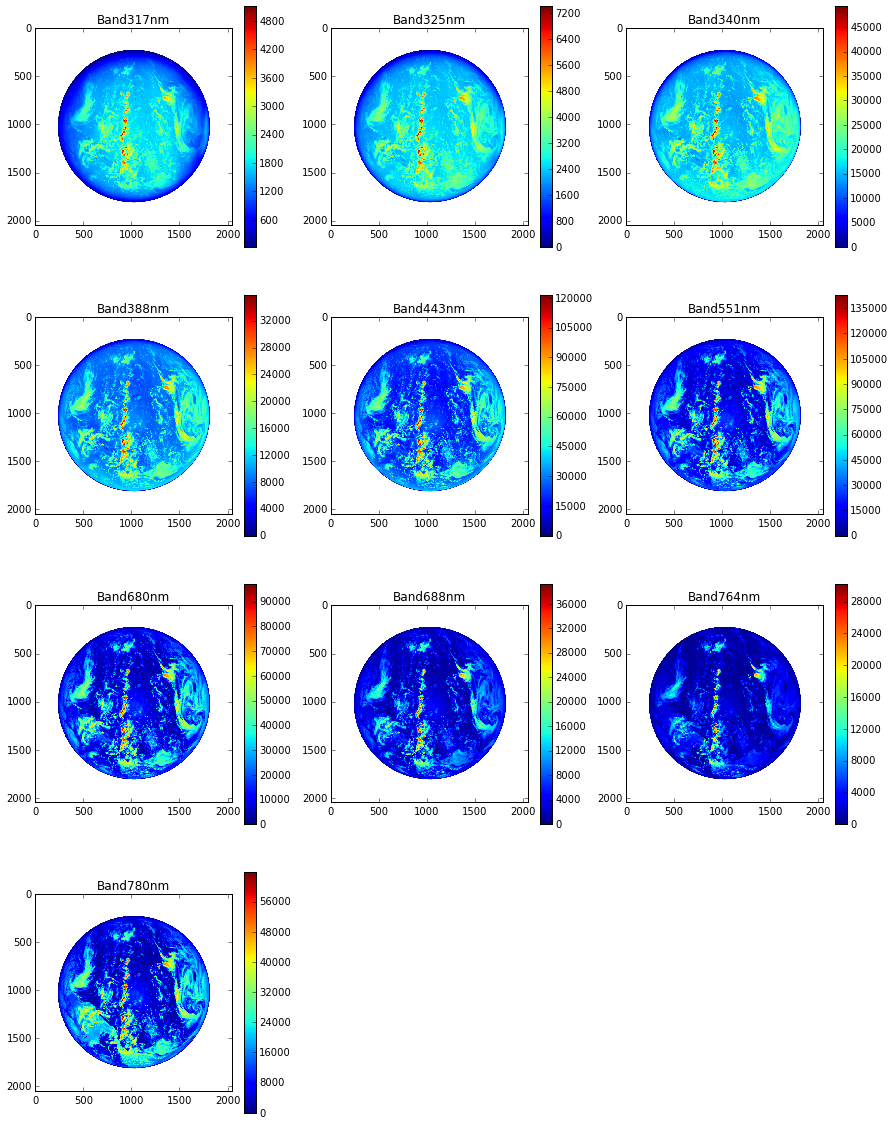

In [6]:
figsize(15, 25)

fig = plt.figure()

i = 1
for band in img:
    a = fig.add_subplot(5, 3, i)
    plt.imshow(img[band]['Image'])
    plt.colorbar()
    a.set_title(band)
    i += 1
    
plt.show()

We can see that the range of pixel values vary quite wildly by band (due, presumably, to the absorbtion of the filters and the sensitivity of the sensor).

Non-Earth pixels are masked out with a value of infinity in the L1B data. (They're preserved in in L1A but pretty much all you can see is cosmic rays.)

We can plot individual histograms of the luminance by band:

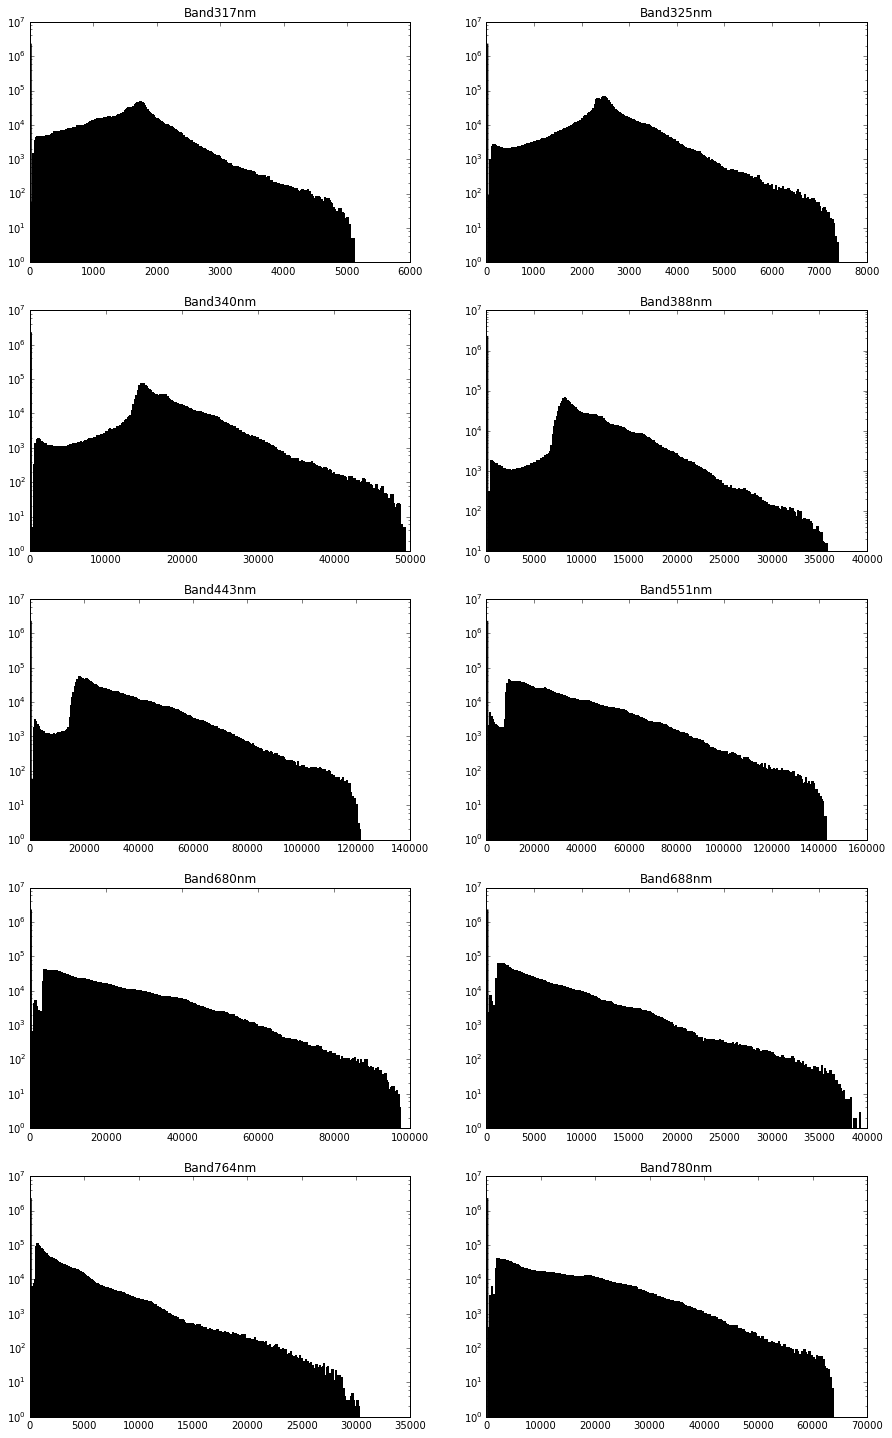

In [7]:
figsize(15, 25)

fig = plt.figure()

i = 1
for band in img:
    a = fig.add_subplot(5, 2, i)
    # Replace infinity with 0
    arr = numpy.ma.fix_invalid(np.array(img[band]['Image']), fill_value=0)
    plt.yscale('log', nonposy='clip')
    plt.hist(arr.ravel(), bins=256, fc='k', ec='k')
    a.set_title(band)
    i += 1
    
plt.show()

Now we'll try and put together a simple RGB image. We pick the bands which are closest to the middle of the visible colour ranges, rotate them so north is up, stack them into a RGB image, and apply a bit of image processing:

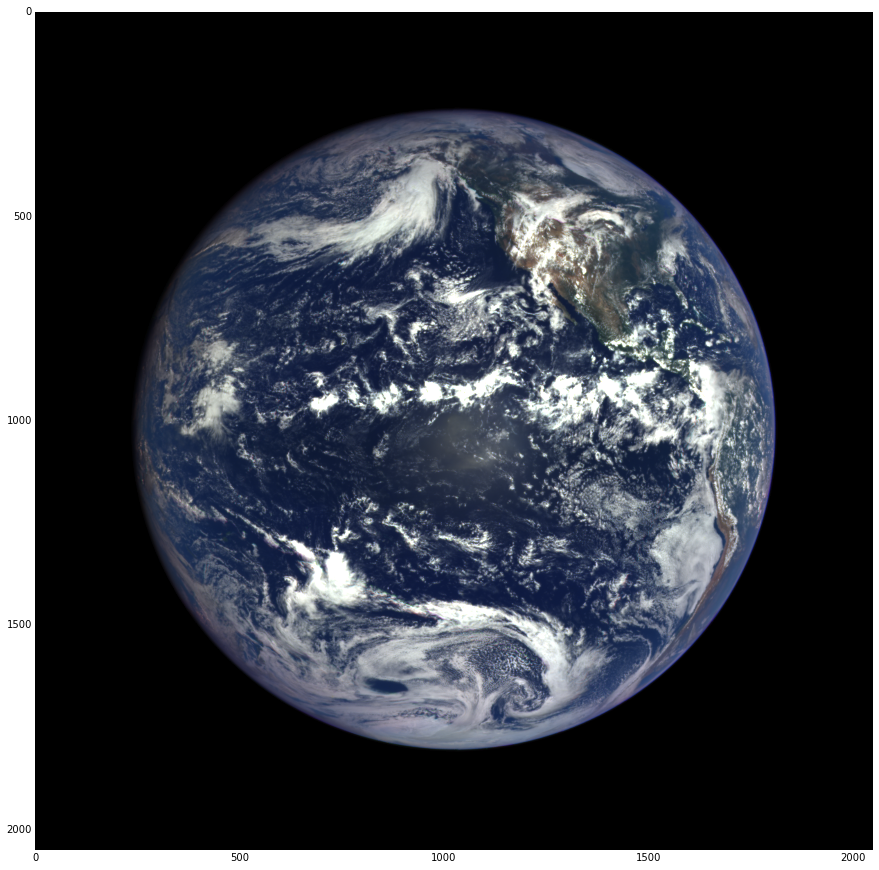

In [13]:
# Select three bands to use as RGB
red_band = img['Band680nm']
green_band = img['Band551nm']
blue_band = img['Band443nm']

def get_image(band):
    # Non-Earth pixels are infinity, fill them to black
    img = np.ma.fix_invalid(np.array(band['Image']), fill_value=0)

    # Flip/rotate the image so North is up:
    img = np.fliplr(np.rot90(img, -1))
    return img

def build_rgb(red, green, blue):
    # Apply some simple colour correction
    green *= 0.90
    red *= 1.25
    # Normalise the image to a floating point 0-1 range, and stack the images into a 3D array
    max_value = max(red.max(), green.max(), blue.max())
    rgb = np.dstack((red/max_value, green/max_value, blue/max_value))
    # Exposure correction:
    rgb = np.clip(rgb * 1.8, 0, 1)
    return rgb

figsize(15, 25)
plt.imshow(build_rgb(get_image(red_band), get_image(green_band), get_image(blue_band)))